In [2]:
import pandas as pd
import seaborn as sns
import plotly.graph_objects as go
import matplotlib.pyplot as plt

In [3]:
df3=pd.read_csv(r"C:\Users\GPSantana\Downloads\Piramide de población.csv",sep=';')

df3['Total'] = (
    df3['Total']
    .astype(str)
    .str.replace('.', '', regex=False)
    .str.replace(',', '.', regex=False)
)
df3['Total'] = pd.to_numeric(df3['Total'], errors='coerce')

df3 = df3[df3['Españoles/Extranjeros'] == 'TOTAL']
df3 = df3[df3['Edad (grupos quinquenales)'] != 'TOTAL EDADES'].copy()
# Normalizar: quitar espacios y pasar a minúsculas
df3['Sexo'] = df3['Sexo'].astype(str).str.strip().str.lower()

# Filtrar manteniendo sólo Hombres y Mujeres (más seguro que excluir 'ambos')
df3 = df3[df3['Sexo'].isin(['hombres', 'mujeres'])].copy()

df3['Sexo'] = df3['Sexo'].replace({
    'hombres': 'Hombres',
    'mujeres': 'Mujeres'
})

df3

,Edad (grupos quinquenales),Españoles/Extranjeros,Sexo,Periodo,Total
250,0-4 años,TOTAL,Hombres,2022,929686
251,0-4 años,TOTAL,Hombres,2021,969383
252,0-4 años,TOTAL,Hombres,2020,1018039
253,0-4 años,TOTAL,Hombres,2019,1048153
254,0-4 años,TOTAL,Hombres,2018,1068953
...,...,...,...,...,...
4795,100 años y más,TOTAL,Mujeres,2002,6016
4796,100 años y más,TOTAL,Mujeres,2001,5953
4797,100 años y más,TOTAL,Mujeres,2000,4079
4798,100 años y más,TOTAL,Mujeres,1999,3434


In [4]:

fig = go.Figure()

def edad_inicial(grupo):
    if isinstance(grupo, str):
        if grupo[0].isdigit():
            try:
                return int(grupo.split('-')[0])
            except ValueError:
                pass
        if "100" in grupo:
            return 100
    return None



for year in sorted(df3['Periodo'].unique()):
    data_year = df3[df3['Periodo'] == year].pivot_table(
        index='Edad (grupos quinquenales)',
        columns='Sexo',
        values='Total',
        aggfunc='sum'
    )

    data_year['edad_inicial'] = data_year.index.map(edad_inicial)
    data_year = data_year.sort_values('edad_inicial').drop(columns='edad_inicial')

    
    fig.add_trace(go.Bar(
        y=data_year.index,
        x=-data_year['Hombres'],
        name='Hombres',
        orientation='h',
        marker_color='steelblue',
        visible=(year == 1998)))

    fig.add_trace(go.Bar(
        y=data_year.index,
        x=data_year['Mujeres'],
        name='Mujeres',
        orientation='h',
        marker_color='lightcoral',
        visible=(year == 1998)))

steps = []
years = sorted(df3['Periodo'].unique())

for i, year in enumerate(years):
    step = dict(
        method="update",
        args=[{"visible": [False] * len(fig.data)},
              {"title": f"Pirámide poblacional España {year}"}],
        label=str(year)
    )

    step["args"][0]["visible"][i*2:(i*2)+2] = [True, True]
    steps.append(step)

sliders = [dict(
    active=years.index(1998),
    currentvalue={"prefix": "Año: "},
    pad={"t": 50},
    steps=steps
)]

fig.update_layout(
    title="Pirámide poblacional España 1998–2022",
    xaxis=dict(title="Población", tickvals=[-3e6, -2e6, -1e6, 0, 1e6, 2e6, 3e6],
               ticktext=['3M', '2M', '1M', '0', '1M', '2M', '3M'],
               range=[-3.5e6, 3.5e6]),
    yaxis=dict(title="Edad (grupos quinquenales)"),
    barmode='overlay',
    sliders=sliders,
    template='plotly_white',
    height=800
)

fig.show()

In [5]:
df4=pd.read_csv(r"C:\Users\GPSantana\Downloads\Proyeccion poblacion 2024-2070.csv",sep=';')

df4['Total'] = (
    df4['Total']
    .astype(str)
    .str.replace('.', '', regex=False)
    .str.replace(',', '.', regex=False))

df4['Total'] = pd.to_numeric(df4['Total'], errors='coerce')

df4 = df4[df4['Sexo'] != 'Total']

def edad_inicial(grupo):
    if isinstance(grupo, str):
        if grupo[0].isdigit():
            try:
                return int(grupo.split('-')[0])
            except:
                pass
        if '100' in grupo:
            return 100
    return None

df4['edad_inicial'] = df4['Edad'].map(edad_inicial)

df4 = df4.sort_values('edad_inicial').drop(columns='edad_inicial')

df4 = df4.sort_values('Periodo')
def edad_a_int(edad):
    if isinstance(edad, str):
        if '100' in edad:
            return 100
        num = ''.join(c for c in edad if c.isdigit())
        if num:
            return int(num)
    return None 


df4['Edad'] = df4['Edad'].apply(edad_a_int)

df4 = df4[df4['Edad'].notna()].copy()

df4['Edad'] = df4['Edad'].astype(int)

df4= df4.sort_values('Edad')

def grupo_quinquenal(edad):
    if edad >= 100:
        return '100 y más'
    start = (edad // 5) * 5
    end = start + 4
    return f'{start}-{end} años'

df4['Edad (grupos quinquenales)'] = df4['Edad'].apply(grupo_quinquenal)

df4_quinquenal = df4.groupby(['Periodo','Sexo','Edad (grupos quinquenales)'])['Total'].sum().reset_index()

df4_quinquenal = df4_quinquenal[df4_quinquenal['Sexo'].isin(['Hombres', 'Mujeres'])].copy()

df4_quinq = df4_quinquenal[['Edad (grupos quinquenales)', 'Sexo', 'Periodo', 'Total']]
df4_quinq['Edad_inicial'] = df4_quinq['Edad (grupos quinquenales)'].str.extract(r'^(\d+)').astype(int)
df4_quinq = df4_quinq.sort_values('Edad_inicial').drop(columns='Edad_inicial')

df4_quinq

C:\Users\GPSantana\AppData\Local\Temp\ipykernel_1060\1062227003.py:61: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Edad (grupos quinquenales),Sexo,Periodo,Total
0,0-4 años,Hombres,2024,8.928310e+05
21,0-4 años,Mujeres,2024,8.446710e+05
735,0-4 años,Mujeres,2041,9.949763e+05
714,0-4 años,Hombres,2041,1.054668e+06
1806,0-4 años,Hombres,2067,9.985436e+05
...,...,...,...,...
1682,100 y más,Hombres,2064,3.611534e+04
1724,100 y más,Hombres,2065,3.814996e+04
1745,100 y más,Mujeres,2065,1.472926e+05
2,100 y más,Hombres,2024,2.962000e+03


In [6]:
df_full = pd.concat([df3, df4_quinq], ignore_index=True)

def edad_inicial(grupo):
    if isinstance(grupo, str):
        if grupo[0].isdigit():
            try:
                return int(grupo.split('-')[0])
            except:
                pass
        if '100' in grupo:
            return 100
    return None

df_full

,Edad (grupos quinquenales),Españoles/Extranjeros,Sexo,Periodo,Total
0,0-4 años,TOTAL,Hombres,2022,9.296860e+05
1,0-4 años,TOTAL,Hombres,2021,9.693830e+05
2,0-4 años,TOTAL,Hombres,2020,1.018039e+06
3,0-4 años,TOTAL,Hombres,2019,1.048153e+06
4,0-4 años,TOTAL,Hombres,2018,1.068953e+06
...,...,...,...,...,...
3187,100 y más,NaN,Hombres,2064,3.611534e+04
3188,100 y más,NaN,Hombres,2065,3.814996e+04
3189,100 y más,NaN,Mujeres,2065,1.472926e+05
3190,100 y más,NaN,Hombres,2024,2.962000e+03


In [130]:
df_full.to_csv(r"C:\Users\GPSantana\Downloads\proyeccion_poblacion_1998_2070.csv", index=False)

In [7]:

fig = go.Figure()

for year in sorted(df_full['Periodo'].unique()):
    data_year = df_full[df_full['Periodo'] == year].pivot_table(
        index='Edad (grupos quinquenales)',
        columns='Sexo',
        values='Total',
        aggfunc='sum'
    )

    data_year['orden'] = data_year.index.map(edad_inicial)
    data_year = data_year.sort_values('orden').drop(columns='orden')

    fig.add_trace(go.Bar(
        y=data_year.index,
        x=-data_year['Hombres'],
        name='Hombres',
        orientation='h',
        marker_color='steelblue',
        visible=(year==1998)
    ))

    fig.add_trace(go.Bar(
        y=data_year.index,
        x=data_year['Mujeres'],
        name='Mujeres',
        orientation='h',
        marker_color='lightcoral',
        visible=(year==1998)
    ))

steps = []
years = sorted(df_full['Periodo'].unique())
for i, year in enumerate(years):
    step = dict(
        method="update",
        args=[{"visible": [False]*len(fig.data)},
              {"title": f"Pirámide poblacional España {year}"}],
        label=str(year)
    )
    step["args"][0]["visible"][i*2:(i*2)+2] = [True, True]
    steps.append(step)

sliders = [dict(
    active=0,
    currentvalue={"prefix":"Año: "},
    pad={"t":50},
    steps=steps
)]

fig.update_layout(
    title="Pirámide poblacional España 1998–2070 (histórico + proyección INE)",
    xaxis=dict(
        title="Población",
        tickvals=[-3e6, -2e6, -1e6, 0, 1e6, 2e6, 3e6],
        ticktext=['3M','2M','1M','0','1M','2M','3M'],
        range=[-3.5e6,3.5e6]
    ),
    yaxis=dict(title="Edad (grupos quinquenales)"),
    barmode='overlay',
    sliders=sliders,
    template='plotly_white',
    height=800
)

fig.show()

In [8]:

df_full = pd.concat([df3, df4_quinq], ignore_index=True)


def edad_inicial(grupo):
    if isinstance(grupo, str):
        if grupo[0].isdigit():
            try:
                return int(grupo.split('-')[0])
            except:
                pass
        if '100' in grupo:
            return 100
    return None

fig = go.Figure()


for year in sorted(df_full['Periodo'].unique()):
    data_year = df_full[df_full['Periodo'] == year].pivot_table(
        index='Edad (grupos quinquenales)',
        columns='Sexo',
        values='Total',
        aggfunc='sum'
    )

    data_year['orden'] = data_year.index.map(edad_inicial)
    data_year = data_year.sort_values('orden').drop(columns='orden')

    fig.add_trace(go.Bar(
        y=data_year.index,
        x=-data_year['Hombres'],
        name='Hombres',
        orientation='h',
        marker_color='steelblue',
        visible=(year == 1998)
    ))

    fig.add_trace(go.Bar(
        y=data_year.index,
        x=data_year['Mujeres'],
        name='Mujeres',
        orientation='h',
        marker_color='lightcoral',
        visible=(year == 1998)
    ))


steps = []
years = sorted(df_full['Periodo'].unique())
for i, year in enumerate(years):
    step = dict(
        method="update",
        args=[{"visible": [False]*len(fig.data)},
              {"title": f"Pirámide poblacional España {year}"}],
        label=str(year)
    )
    step["args"][0]["visible"][i*2:(i*2)+2] = [True, True]
    steps.append(step)

sliders = [dict(
    active=0,
    currentvalue={"prefix":"Año: "},
    pad={"t":50},
    steps=steps
)]


fig.update_layout(
    title="Pirámide poblacional España 1998–2070 (histórico + proyección INE)",
    xaxis=dict(
        title="Población",
        tickvals=[-4e6, -3e6, -2e6, -1e6, 0, 1e6, 2e6, 3e6, 4e6],
        ticktext=['4M','3M','2M','1M','0','1M','2M','3M','4M'],
        range=[-4.5e6, 4.5e6] 
    ),
    yaxis=dict(title="Edad (grupos quinquenales)"),
    barmode='overlay',
    sliders=sliders,
    template='plotly_white',
    height=800
)

fig.show()


In [9]:
df_full.head()

,Edad (grupos quinquenales),Españoles/Extranjeros,Sexo,Periodo,Total
0,0-4 años,TOTAL,Hombres,2022,929686.0
1,0-4 años,TOTAL,Hombres,2021,969383.0
2,0-4 años,TOTAL,Hombres,2020,1018039.0
3,0-4 años,TOTAL,Hombres,2019,1048153.0
4,0-4 años,TOTAL,Hombres,2018,1068953.0


In [10]:
df_flour = df_full.copy()

df_pivot = df_flour.pivot_table(
    index=['Periodo', 'Edad (grupos quinquenales)'],  # índice múltiple
    columns='Sexo',
    values='Total',
    aggfunc='sum'  # en caso de duplicados
).reset_index()  # opcional si quieres que Periodo y Edad vuelvan a ser columnas

# Reordenar columnas para que quede más limpio
df_pivot = df_pivot[['Periodo', 'Edad (grupos quinquenales)', 'Hombres', 'Mujeres']]

print(df_pivot.head())


Sexo  Periodo Edad (grupos quinquenales)    Hombres    Mujeres
0        1998                   0-4 años   875176.0   834836.0
1        1998                 10-14 años  1172851.0  1114047.0
2        1998             100 años y más      783.0     2691.0
3        1998                 15-19 años  1503079.0  1429601.0
4        1998                 20-24 años  1711858.0  1641868.0


In [11]:
df_pyramid = df_pivot.copy()

df_pyramid['Hombres'] = -df_pyramid['Hombres']

print(df_pyramid.head())

Sexo  Periodo Edad (grupos quinquenales)    Hombres    Mujeres
0        1998                   0-4 años  -875176.0   834836.0
1        1998                 10-14 años -1172851.0  1114047.0
2        1998             100 años y más     -783.0     2691.0
3        1998                 15-19 años -1503079.0  1429601.0
4        1998                 20-24 años -1711858.0  1641868.0


In [12]:
df_pyramid['Periodo'] = df_pyramid['Periodo'].astype(int)

df_pyramid = df_pyramid.sort_values(by='Periodo', ascending=False)

df_pyramid = df_pyramid.reset_index(drop=True)

print(df_pyramid.head())


Sexo  Periodo Edad (grupos quinquenales)       Hombres       Mujeres
0        2074                 95-99 años -2.214454e+05  4.974318e+05
1        2074                 90-94 años -5.102260e+05  8.522121e+05
2        2074                 85-89 años -8.013527e+05  1.103933e+06
3        2074                 75-79 años -1.320053e+06  1.503909e+06
4        2074                 80-84 años -1.092507e+06  1.333500e+06


In [13]:
df_pyramid['edad_start'] = df_pyramid['Edad (grupos quinquenales)'].str.extract(r'(\d+)').astype(int)


In [14]:
df_pyramid = df_pyramid.sort_values(
    by=['Periodo', 'edad_start'],
    ascending=[False, True]  # Periodo descendente, edades ascendentes
).reset_index(drop=True)


In [15]:
df_pyramid = df_pyramid.drop(columns='edad_start')


In [16]:
for year in df_pyramid["Periodo"].unique():
    df_year = df_pyramid[df_pyramid["Periodo"] == year]
    df_year.to_csv(f'piramide_{year}.csv', index=False)


In [17]:
df_pyramid.to_csv(r"C:\Users\GPSantana\Downloads\piramide_poblacion_1998_2070.csv", index=False)

In [18]:
df = df_full.copy()


jovenes = ["0-4 años","5-9 años","10-14 años"]

laboral = [
    "15-19 años","20-24 años","25-29 años","30-34 años","35-39 años",
    "40-44 años","45-49 años","50-54 años","55-59 años","60-64 años"
]

mayores = [
    "65-69 años","70-74 años","75-79 años","80-84 años","85-89 años",
    "90-94 años","95-99 años","100 años y más"
]


result = df.pivot_table(
    index="Periodo",
    columns="Edad (grupos quinquenales)",
    values="Total",
    aggfunc="sum"
)


result["p_jovenes"] = result[jovenes].sum(axis=1)
result["p_laboral"] = result[laboral].sum(axis=1)
result["p_mayores"] = result[mayores].sum(axis=1)

result["Índice de Dependencia"] = (result["p_jovenes"] + result["p_mayores"]) / result["p_laboral"] * 100
result["razon_dependencia_joven"] = (result["p_jovenes"] / result["p_laboral"]) * 100
result["razon_dependencia_mayor"] = (result["p_mayores"] / result["p_laboral"]) * 100

result.index.name = "Periodo"
result = result.reset_index().set_index("Periodo")

print(result[["Índice de Dependencia","razon_dependencia_joven","razon_dependencia_mayor"]])


Edad (grupos quinquenales)  Índice de Dependencia  razon_dependencia_joven  \
Periodo                                                                      
1998                                    45.945009                22.135969   
1999                                    46.094607                21.603049   
2000                                    45.822358                21.112556   
2001                                    45.652468                20.722611   
2002                                    45.472747                20.544205   
...                                           ...                      ...   
2070                                    69.270226                18.976945   
2071                                    69.534862                19.099608   
2072                                    69.871430                19.239999   
2073                                    70.252618                19.392148   
2074                                    70.742180               

In [139]:
result.to_csv(r"C:\Users\GPSantana\Downloads\proyeccion_razon_dependencia_1998_2070.csv", index=True)

In [19]:
result  

Edad (grupos quinquenales),0-4 años,10-14 años,100 años y más,100 y más,15-19 años,20-24 años,25-29 años,30-34 años,35-39 años,40-44 años,...,80-84 años,85-89 años,90-94 años,95-99 años,p_jovenes,p_laboral,p_mayores,Índice de Dependencia,razon_dependencia_joven,razon_dependencia_mayor
Periodo,,,,,,,,,,,,,,,,,,,,,
1998,1.710012e+06,2.286898e+06,3474.0,NaN,2.932680e+06,3.353726e+06,3.255862e+06,3.245232e+06,3.024704e+06,2.674025e+06,...,8.019320e+05,4.575650e+05,1.607210e+05,35590.000000,6.044585e+06,2.730662e+07,6.501444e+06,45.945009,22.135969,23.809040
1999,1.688936e+06,2.248148e+06,4680.0,NaN,2.805795e+06,3.354877e+06,3.284083e+06,3.264850e+06,3.085977e+06,2.772113e+06,...,8.237650e+05,4.767340e+05,1.716510e+05,39069.000000,5.944704e+06,2.751789e+07,6.739561e+06,46.094607,21.603049,24.491558
2000,1.680988e+06,2.198661e+06,5760.0,NaN,2.682891e+06,3.310735e+06,3.375781e+06,3.321008e+06,3.192124e+06,2.884950e+06,...,8.307660e+05,4.923380e+05,1.837520e+05,42620.000000,5.863669e+06,2.777337e+07,6.862746e+06,45.822358,21.112556,24.709803
2001,1.719672e+06,2.165410e+06,8766.0,NaN,2.581186e+06,3.288805e+06,3.493759e+06,3.405724e+06,3.291771e+06,3.013529e+06,...,8.732710e+05,5.071740e+05,1.987010e+05,45128.000000,5.849872e+06,2.822942e+07,7.037553e+06,45.652468,20.722611,24.929857
2002,1.794363e+06,2.156157e+06,8719.0,NaN,2.502700e+06,3.249598e+06,3.626324e+06,3.515143e+06,3.415251e+06,3.130560e+06,...,9.173940e+05,5.076180e+05,2.031790e+05,46132.000000,5.908504e+06,2.875995e+07,7.169437e+06,45.472747,20.544205,24.928541
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2070,1.986886e+06,2.093006e+06,NaN,218937.712841,2.283774e+06,2.607840e+06,2.936993e+06,3.144438e+06,3.231414e+06,3.270626e+06,...,2.447724e+06,2.054108e+06,1.467379e+06,670897.637401,6.092595e+06,3.210525e+07,1.614678e+07,69.270226,18.976945,50.293282
2071,2.002002e+06,2.093569e+06,NaN,225109.078744,2.269862e+06,2.592277e+06,2.935291e+06,3.163058e+06,3.256108e+06,3.296349e+06,...,2.432783e+06,2.004489e+06,1.452996e+06,686953.313580,6.121288e+06,3.204929e+07,1.616414e+07,69.534862,19.099608,50.435254
2072,2.016482e+06,2.097335e+06,NaN,231656.927909,2.258323e+06,2.575859e+06,2.930213e+06,3.177881e+06,3.281033e+06,3.321719e+06,...,2.425481e+06,1.962089e+06,1.427309e+06,702278.966117,6.153643e+06,3.198359e+07,1.619375e+07,69.871430,19.239999,50.631431


<Axes: xlabel='Periodo'>

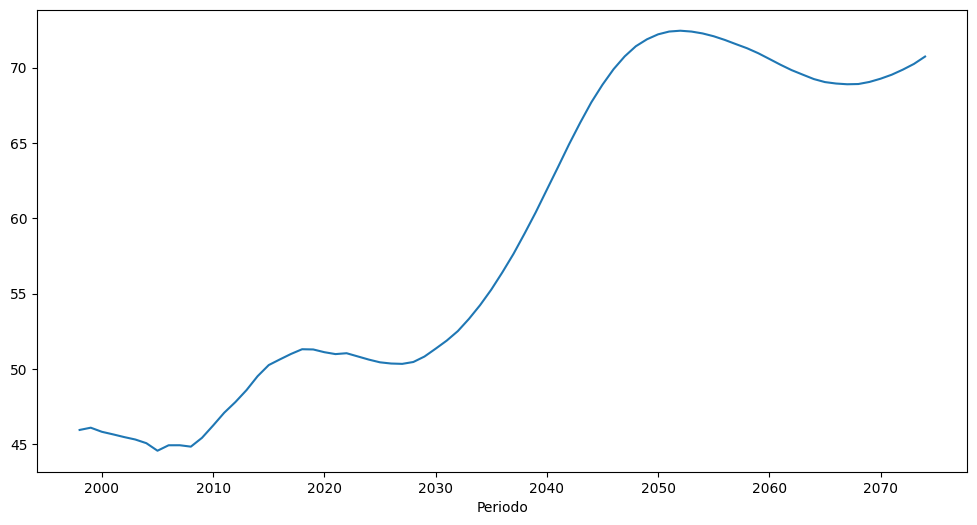

In [20]:
result["Índice de Dependencia"].plot(kind="line", figsize=(12,6))

In [21]:
pib = pd.read_csv(r"C:\Users\GPSantana\Downloads\PIB.csv",sep=",", skiprows=3)

pib

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2016,2017,2018,2019,2020,2021,2022,2023,2024,Unnamed: 69
0,Aruba,ABW,Crecimiento del PIB (% anual),NY.GDP.MKTP.KD.ZG,NaN,NaN,NaN,NaN,NaN,NaN,...,1.719625,7.048533,2.397086,-2.232442,-26.211820,24.132627,8.517918,4.263719,NaN,NaN
1,NaN,AFE,Crecimiento del PIB (% anual),NY.GDP.MKTP.KD.ZG,NaN,0.469708,7.868623,5.622472,4.689533,5.159536,...,2.195991,2.696238,2.665038,2.200340,-2.859784,4.563568,3.555769,1.891307,2.766804,NaN
2,Afganistán,AFG,Crecimiento del PIB (% anual),NY.GDP.MKTP.KD.ZG,NaN,NaN,NaN,NaN,NaN,NaN,...,2.260314,2.647003,1.189228,3.911603,-2.351101,-20.738839,-6.240172,2.266944,NaN,NaN
3,NaN,AFW,Crecimiento del PIB (% anual),NY.GDP.MKTP.KD.ZG,NaN,1.869637,3.725941,7.039191,5.364761,4.105616,...,0.194177,2.296168,2.904654,3.282163,-0.984117,4.030000,3.974964,3.357987,4.176103,NaN
4,Angola,AGO,Crecimiento del PIB (% anual),NY.GDP.MKTP.KD.ZG,NaN,NaN,NaN,NaN,NaN,NaN,...,-2.580050,-0.147213,-1.316362,-0.702273,-5.638215,1.199211,3.044727,1.078100,4.423905,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261,Kosovo,XKX,Crecimiento del PIB (% anual),NY.GDP.MKTP.KD.ZG,NaN,NaN,NaN,NaN,NaN,NaN,...,5.571775,4.825656,3.406632,4.756801,-5.340275,10.745656,4.278499,4.067627,4.412738,NaN
262,"Yemen, Rep. del",YEM,Crecimiento del PIB (% anual),NY.GDP.MKTP.KD.ZG,NaN,NaN,NaN,NaN,NaN,NaN,...,-9.375124,-5.071796,0.752448,NaN,NaN,NaN,NaN,NaN,NaN,NaN
263,Sudáfrica,ZAF,Crecimiento del PIB (% anual),NY.GDP.MKTP.KD.ZG,NaN,3.844734,6.177931,7.373709,7.939609,6.122798,...,0.664552,1.157947,1.556784,0.259936,-6.168918,4.955033,1.911480,0.698485,0.579854,NaN
264,Zambia,ZMB,Crecimiento del PIB (% anual),NY.GDP.MKTP.KD.ZG,NaN,1.361382,-2.490839,3.272393,12.214048,16.647456,...,3.755100,3.525863,4.034494,1.441306,-2.785055,6.234922,5.211224,5.367943,4.043148,NaN


In [22]:
pib=pib[pib["Country Name"]== "España"]

pib

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2016,2017,2018,2019,2020,2021,2022,2023,2024,Unnamed: 69
70,España,ESP,Crecimiento del PIB (% anual),NY.GDP.MKTP.KD.ZG,NaN,11.838674,9.953438,9.596499,5.30851,6.253135,...,2.915156,2.896042,2.395411,1.961179,-10.940071,6.683144,6.179312,2.675663,3.150196,NaN


In [23]:
cols_fijas = ['Country Name', 'Country Code', 'Indicator Name']

cols_anios = [col for col in pib.columns if col.isdigit() and 1998 <= int(col) <= 2024]

df_espana_pib = pib[cols_fijas + cols_anios]

df_espana_pib

,Country Name,Country Code,Indicator Name,1998,1999,2000,2001,2002,2003,2004,...,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
70,España,ESP,Crecimiento del PIB (% anual),4.301977,4.408865,5.200641,3.919089,2.755456,2.93929,3.114531,...,4.060867,2.915156,2.896042,2.395411,1.961179,-10.940071,6.683144,6.179312,2.675663,3.150196


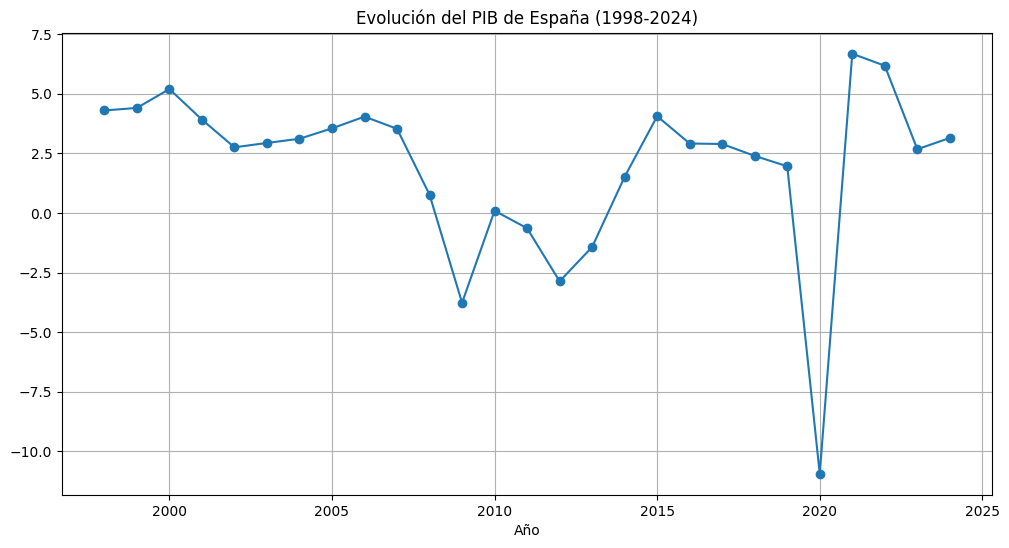

In [24]:
df_plot = df_espana_pib.set_index('Indicator Name')


df_plot = df_plot[cols_anios].T
df_plot.index = df_plot.index.astype(int)

plt.figure(figsize=(12,6))
plt.plot(df_plot.index, df_plot.iloc[:,0], marker='o')
plt.title('Evolución del PIB de España (1998-2024)')
plt.xlabel('Año')
plt.ylabel(df_plot.index.name)
plt.grid(True)
plt.show()